In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)

raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))

# 1. Load your data
# Suppose df has columns ["timestamp", "feature1", "feature2", …].
df = vrun_bar[-(60*24*7):].copy()
periods = [1, 2, 4, 6, 8, 10]
for period in periods:
    df[f'pct_fwd_{period}'] = np.log1p(df["close"].pct_change(periods=-period).fillna(0))
    df[f'pct_bak_{period}'] = np.log1p(df["close"].pct_change(periods=period).fillna(0))

for i, period in enumerate(periods):
    df[f'pct_cum_fwd_{period}'] = sum(df[f'pct_fwd_{p}'] for p in periods[:(i+1)])
    df[f'pct_cum_bak_{period}'] = sum(df[f'pct_bak_{p}'] for p in periods[:(i+1)])
    df[f'f_p_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x > 0 else 0)
    df[f'f_n_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x <= 0 else 0)
X = df[[f'f_p_{p}' for p in periods]+[f'f_n_{p}' for p in periods]]

# 2. Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Instantiate GaussianHMM
n_states = 2  # choose your number of regimes
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=30,
    verbose=True,    # print convergence info
    random_state=0,
)

# 4. Fit model
model.fit(X_scaled)

# 5. Decode with Viterbi
hidden_states = model.predict(X_scaled)

# 6. Attach labels to df
df["hmm_state"] = hidden_states

raw = raw_bar[-(60*24*7):]

# Initialize empty DataFrame to hold mean returns
hmm_stats = pd.DataFrame(
    index=sorted(df["hmm_state"].unique()), 
    columns=[f"fut_return_{p}" for p in periods]
)

for period in periods:
    col_name = f"fut_return_{period}"
    
    # Calculate future returns
    df[col_name] = df.groupby("hmm_state")["close"].transform(
        lambda x: x.shift(-period) / x - 1
    )
    
    # Compute mean for each hmm_state and store in hmm_stats
    stats = df.groupby("hmm_state")[col_name].agg(['mean'])
    hmm_stats.loc[:, col_name] = stats['mean']

print(hmm_stats)

# df.set_index('time', inplace=True)
# raw.index.name = 'time'
# merged = pd.merge(df[['close', "hmm_state"]], raw['close'], on='time', how='left')
# print(merged)

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

# Add HMM scatter with custom color mapping
fig.add_trace(go.Scatter(
    y=df['close'],
    mode='markers',
    marker=dict(
        color=df['hmm_state'],
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title="HMM State"),
        size=6
    ),
    name="Close",
))
fig.show()

         1  -42295.82775079             +nan
         2  -17979.13778594  +24316.68996485
         3   -7139.41713298  +10839.72065296
         4     943.75928822   +8083.17642120
         5   10173.16182283   +9229.40253461
         6   14268.09283468   +4094.93101185
         7   16732.07920975   +2463.98637506
         8   18470.87198250   +1738.79277275
         9   22660.12627907   +4189.25429656
        10   29191.75276281   +6531.62648375
        11   31037.46578515   +1845.71302233
        12   31671.13205965    +633.66627450
        13   32423.66955218    +752.53749253
        14   33928.82913035   +1505.15957817
        15   36714.54141842   +2785.71228807
        16   39955.59952196   +3241.05810354
        17   44349.41354297   +4393.81402101
        18   50071.01448906   +5721.60094610
        19   60549.53478568  +10478.52029662
        20   74984.19232061  +14434.65753493
        21   91981.90997177  +16997.71765116
        22   91866.04485433    -115.86511744
Model is n

  fut_return_1 fut_return_2 fut_return_4 fut_return_6 fut_return_8  \
0     0.000023     0.000047     0.000094     0.000142      0.00019   
1     0.000027     0.000053     0.000105     0.000161     0.000216   

  fut_return_10  
0      0.000239  
1      0.000272  


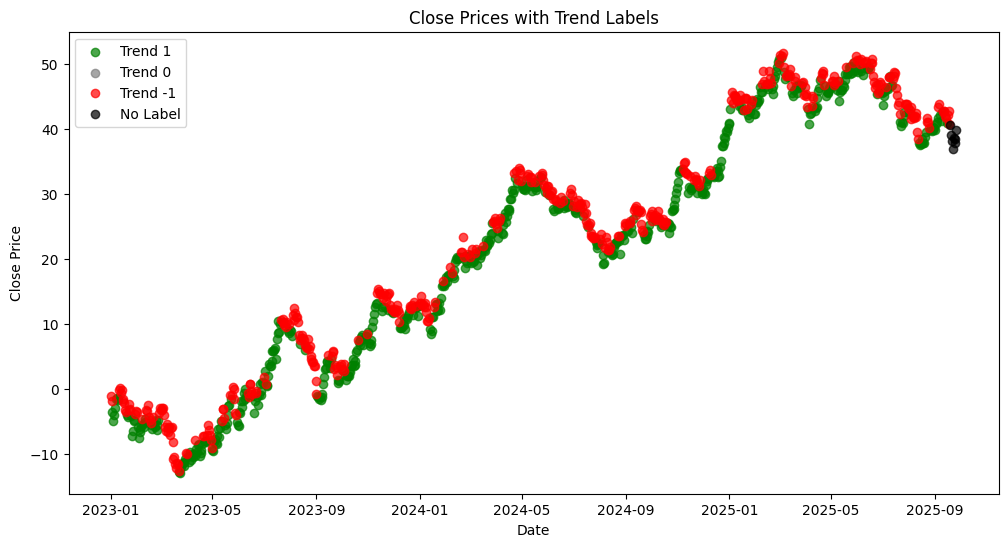

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to compute the t-value of the linear trend
def tValLinR(close):
    """
    Compute the t-value for the slope of a linear trend.
    
    Parameters:
    - close: Array-like, the sequence of observations.
    
    Returns:
    - float: The t-value of the trend slope.
    """
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sm.OLS(close, x).fit()
    return ols.tvalues[1]

# Function to get labels from the trend-scanning method
def getBinsFromTrend(molecule, close, span):
    """
    Derive labels from the sign of t-value of linear trend.
    
    Parameters:
    - molecule: Index of observations to label (e.g., timestamps).
    - close: pandas Series, time series of prices with datetime index.
    - span: Tuple, (start, end) range of look-forward periods to evaluate.
    
    Returns:
    - pandas DataFrame with columns 't1' (end time), 'tVal' (t-value), 'bin' (label).
    """
    out = pd.DataFrame(index=molecule, columns=['t1', 'tVal', 'bin'])
    hrzns = range(*span)
    for dt0 in molecule:
        df0 = pd.Series()
        iloc0 = close.index.get_loc(dt0)
        if iloc0 + max(hrzns) > close.shape[0]:
            continue
        for hrzn in hrzns:
            dt1 = close.index[iloc0 + hrzn - 1]
            df1 = close.loc[dt0:dt1]
            df0.loc[dt1] = tValLinR(df1.values)
        dt1 = df0.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
        out.loc[dt0, ['t1', 'tVal', 'bin']] = df0.index[-1], df0[dt1], np.sign(df0[dt1])  # prevent leakage
    out['t1'] = pd.to_datetime(out['t1'])
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')
    return out.dropna(subset=['bin'])

# Assume df is your DataFrame with 'close' column and datetime index
# Example of how to load your data (uncomment and adjust as needed):
# df = pd.read_csv('your_data.csv', index_col='date', parse_dates=True)
# df['close'] = df['close'].astype(float)

# Set molecule to the index of df (the observations to label)
molecule = df.index

# Define the range of look-forward periods, e.g., (3, 10) for horizons 3 to 9
span = (3, 10)  # Adjust this based on your data frequency and needs

# Get the labels using the trend-scanning method
labels = getBinsFromTrend(molecule, df['close'], span)

# Define colors for the labels
colors = {1: 'green', 0: 'gray', -1: 'red'}  # 1: uptrend, 0: no trend, -1: downtrend

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points with labels
for bin_val, color in colors.items():
    idx = labels[labels['bin'] == bin_val].index
    ax.scatter(idx, df.loc[idx, 'close'], c=color, label=f'Trend {bin_val}', alpha=0.7)

# Plot unlabeled points (if any)
unlabeled_idx = df.index.difference(labels.index)
if not unlabeled_idx.empty:
    ax.scatter(unlabeled_idx, df.loc[unlabeled_idx, 'close'], c='black', label='No Label', alpha=0.7)

# Customize the plot
ax.set_title('Close Prices with Trend Labels')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

In [46]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', None)

# Load data
raw_bar = pd.read_parquet(os.path.join(os.getcwd(), 'history.parquet'))
vrun_bar = pd.read_parquet(os.path.join(os.getcwd(), 'volume_run_bar.parquet'))

# Prepare features
df = vrun_bar[-(60*24*7):].copy()
periods = [1, 2, 4, 6, 8, 10]
for period in periods:
    df[f'pct_fwd_{period}'] = np.log1p(df["close"].pct_change(periods=-period).fillna(0))
    df[f'pct_bak_{period}'] = np.log1p(df["close"].pct_change(periods=period).fillna(0))

for i, period in enumerate(periods):
    df[f'pct_cum_fwd_{period}'] = sum(df[f'pct_fwd_{p}'] for p in periods[:(i+1)])
    df[f'pct_cum_bak_{period}'] = sum(df[f'pct_bak_{p}'] for p in periods[:(i+1)])
    df[f'f_p_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x > 0 else 0)
    df[f'f_n_{period}'] = df[f'pct_cum_fwd_{period}'].apply(lambda x: x if x <= 0 else 0)
X = df[[f'f_p_{p}' for p in periods]+[f'f_n_{p}' for p in periods]]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Higher-order HMM parameters
order = 2  # Set the desired order here
n_states = 3  # Original number of states
new_n_components = n_states ** order  # Expanded state space

# Create constrained transition matrix
transmat = np.zeros((new_n_components, new_n_components))
for i in range(new_n_components):
    prev_state = i // n_states
    current_state = i % n_states
    next_indices = [current_state * n_states + next_state for next_state in range(n_states)]
    transmat[i, next_indices] = 1.0 / len(next_indices)

# Initialize model with custom transitions
model = hmm.GaussianHMM(
    n_components=new_n_components,
    covariance_type="full",
    n_iter=30,
    verbose=True,
    random_state=0,
    init_params='se'  # Initialize startprob and emissions only
)
model.transmat_ = transmat  # Set our custom transition matrix

# Fit model
model.fit(X_scaled)

# Predict and decode states
hidden_states = model.predict(X_scaled)
current_states = hidden_states % n_states  # Extract current state from expanded state
df["hmm_state"] = current_states

# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=df['close'],
    mode='markers',
    marker=dict(
        color=df['hmm_state'],
        colorscale='Plasma',
        showscale=True,
        colorbar=dict(title="HMM State"),
        size=6
    ),
    name="Close",
))
fig.show()

         1  -44241.13941906             +nan
         2    9608.69771630  +53849.83713536
         3   52926.28970205  +43317.59198576
         4   69803.89271136  +16877.60300931
         5   80594.81389702  +10790.92118566
         6   83711.92246035   +3117.10856333
         7   86630.50818776   +2918.58572741
         8   90455.30498917   +3824.79680141
         9  123476.43321124  +33021.12822207
        10  108784.82433439  -14691.60887686
Model is not converging.  Current: 108784.82433438509 is not greater than 123476.43321124124. Delta is -14691.608876856146
